In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

## Merging

Here, we merged four dataframes at different time points in 2021 avaliable from insideairbnb into one dataframe (Mar 21, Jun 21, Sep 21 & Dec 21). In this way, we are treating each listing at each time point as a sample. Then, we will be using the covarites to predict the demand (occupancy rate).One debate for this method is whether treating an identical listing at two different time point as two different samples is appropriate. This may bias our model to learn about a particular pattern but this will also lower the variance for our estimated demand. Another problem is whether we are using testing data to train. For instance, for the reviews_per_month variable, it is natural to see its correlation with the demand of the listings and more reviews_per_month is caused by more demand as more guests implies more reviews. However, in this dataset, the demand is defined as the proportion of avaliability in the future 30, 60, 90 days. Thus, reviews_per_month is still the past data relative to the demand metrics.

In [2]:
df1 = pd.read_csv('Data/listings3.csv')
df2 = pd.read_csv('Data/listings6.csv')
df3 = pd.read_csv('Data/listings9.csv')
df4 = pd.read_csv('Data/listings12.csv')

In [3]:
df_21 = pd.concat([df1, df2, df3, df4])

# EDA

In this report, we did the exploratory data analysis and data cleaning when we spotted any problematic data. As for exploration, we focused on the breadth instead of depth. We shall focus on the depth of those in the next step. The report is arranged as follows: 1. Geographical Analysis, 2. House Type analysis, 3. Real-Estate price analysis, 4. crime-rate analysis.

In [4]:
df_21["price"] = df_21["price"].apply(lambda x: float(x.replace(',','')[1:]))

In [5]:
df_21 = df_21[df_21["price"] > 0] # get rid of nan

As our goal here is to analyze short-term renting. Our definition of "short-term" is that the minimum for minimum nights are smaller than 20 days, if not 0 days.

In [6]:
df_21 = df_21[df_21["minimum_minimum_nights"] < 20]

Here, we eliminate the long-term hosts, but we cannot eliminate long-term renters. For instance, say a renter rented for 1 year consecutively for a house that has rule for minimum of 1 nights. Here, the host is not an intentional long-term host, but the renter here is a long-term renter. One possibility to solve the problem is to also limit the maximum nights so that it is below a threshold. However, by doing so, we are filtering out a much larger proportion of data than the minimum night filtering.

Thus, we need to make a relatively loose threshold for controlling the maximum nights. One other solution is to look at the future 90 day bookings. If future 90 days are fully booked, this likely indicates the renter at this particular house is a long-term renter that he/she booked for a long consecutive time.

In [7]:
(df_21["maximum_maximum_nights"] <= 1000).mean()

0.3257811166126003

We can see that filtering by maximum nights is not a good approach.

In [8]:
(df_21["availability_90"] == 0).mean()

0.24546696260884412

In [9]:
df_21 = df_21[df_21["availability_90"] > 0]

The downside of this filtering method is that it inevitably disposes many houses that are so popular that they are fully booked for the next 90 days.

<AxesSubplot:xlabel='availability_90', ylabel='Density'>

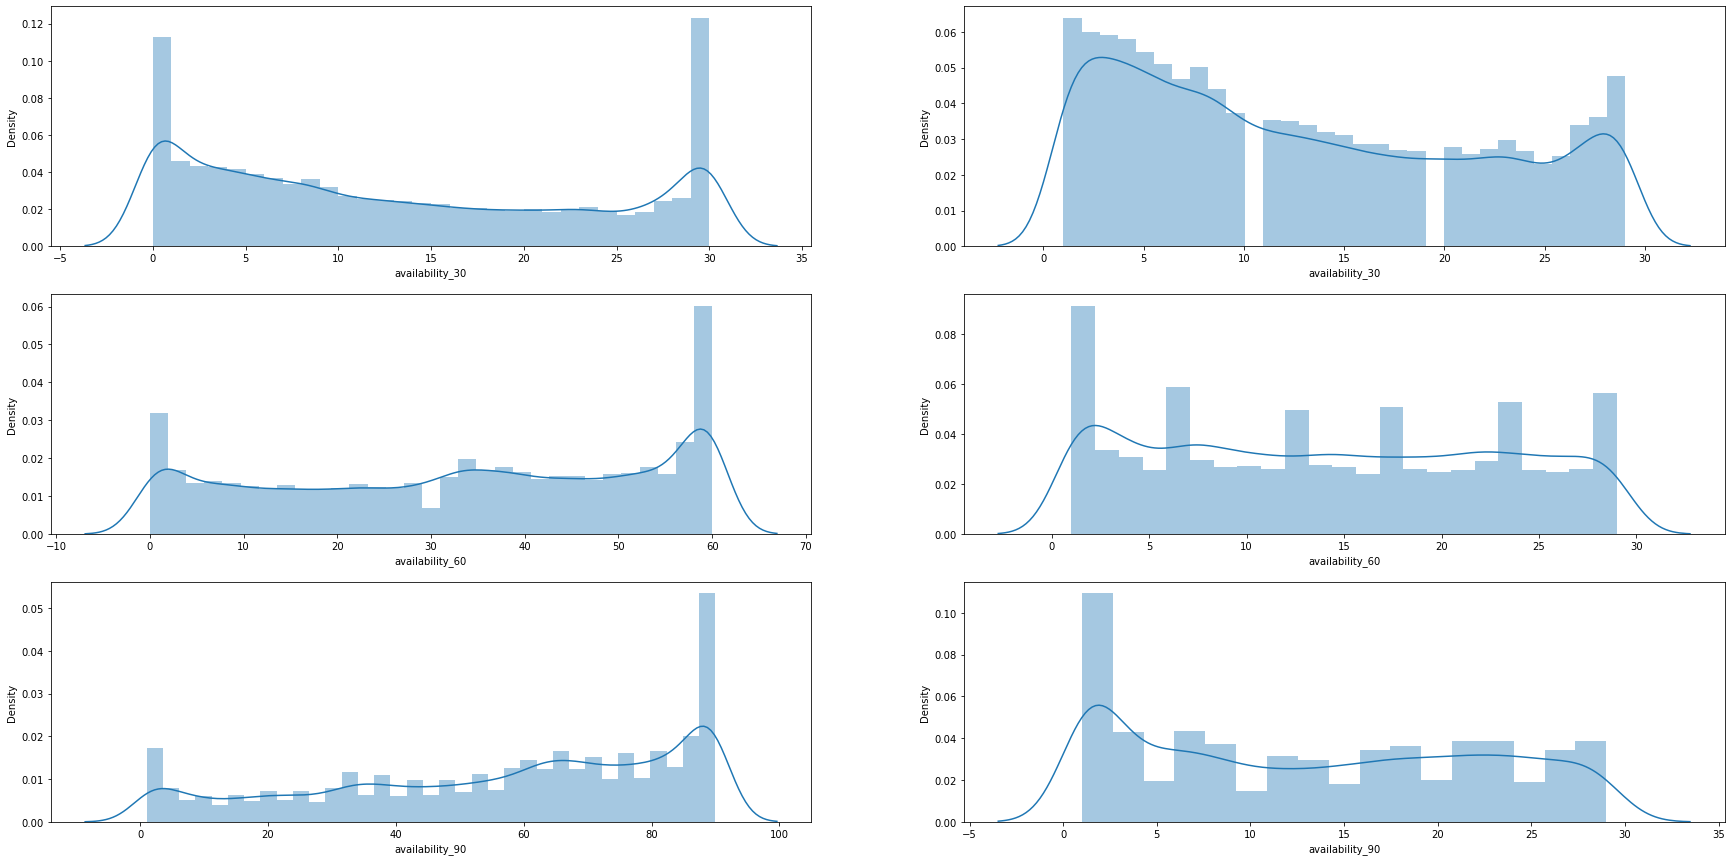

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))
sns.distplot(df_21['availability_30'], ax=axes[0][0])
sns.distplot(df_21['availability_30'][(df_21['availability_30'] > 0) & (df_21['availability_30'] < 30)], ax=axes[0][1])
sns.distplot(df_21['availability_60'], ax=axes[1][0])
sns.distplot(df_21['availability_60'][(df_21['availability_60'] > 0) & (df_21['availability_60'] < 30)], ax=axes[1][1])
sns.distplot(df_21['availability_90'], ax=axes[2][0])
sns.distplot(df_21['availability_90'][(df_21['availability_90'] > 0) & (df_21['availability_90'] < 30)], ax=axes[2][1])


Create a new column of occupancy rate = 2/3 * occupancy rate in 30 days + 1/6 * occupancy rate in 60 days + 1/6 * occupancy rate in 90 days. Note a listing may not be available because it has been booked by a guest or blocked by the host.

In [11]:
# Filter out listings that have no reviews yet to avoid treating an unpopular but blocked listing as a popular listing.
df_21 = df_21[df_21['reviews_per_month'] > 0] 


In [12]:
df_21['occupancy_rate'] = 2/3 * (30 - df_21['availability_30']) / 30 * 100 + 1/6*(60 - df_21['availability_60']) / 60 * 100 + 1/6 * (90 - df_21['availability_90']) / 90 * 100


Here is a brief overview of what the occupancy rate distribution looks like

In [13]:
#df_21.to_csv("df_21.csv")

In [14]:
#df_21 = pd.read_csv("df_21.csv")

In [15]:
import requests
from bs4 import BeautifulSoup

# Geographical Analysis

In the following section, we are intetersed in how geographical factors influence the demand, and price for airbnb listings.

### Maps of occupancy rate distribution across LA

<Figure size 1800x2880 with 0 Axes>

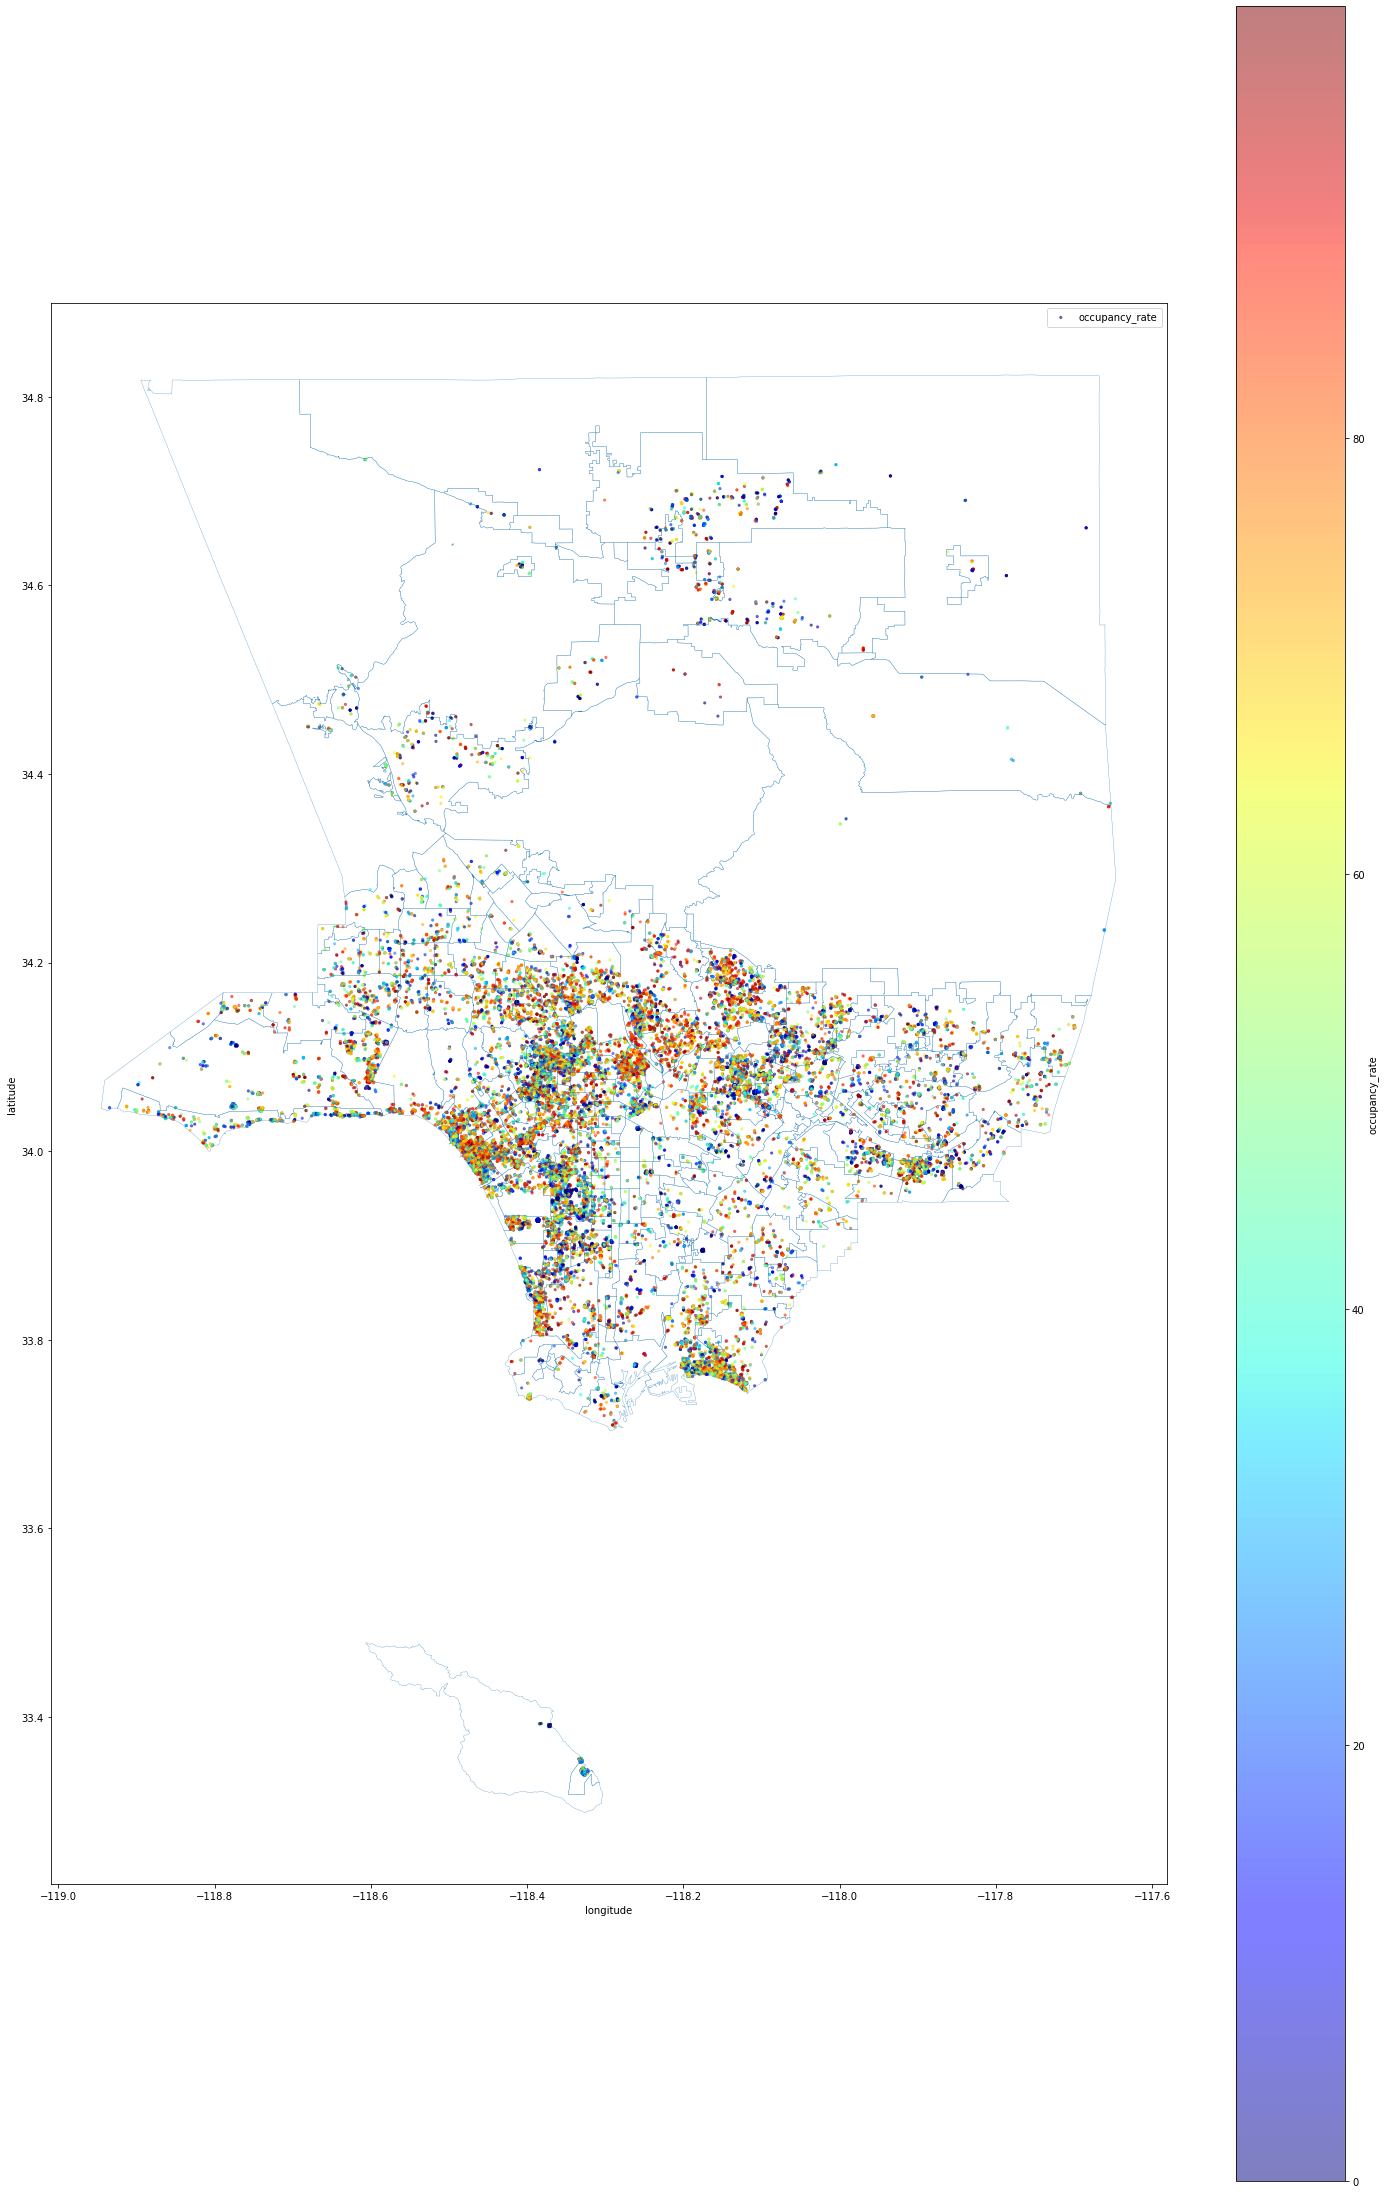

In [16]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(25,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df_21.plot(kind='scatter', x='longitude', y='latitude', label='occupancy_rate', c='occupancy_rate',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.5, s=  5, figsize=(25,40), ax=ax)

plt.legend()
plt.show()

In [17]:
df_21['annual_return'] = df_21.price * df_21.occupancy_rate
df_21["annual_return"][df_21['annual_return'] > 100000] = 100000

### Maps of annual return on all airBnb <= 60000 per year across LA

In [18]:
df_21["annual_return_mid"] = df_21['annual_return']
df_21["annual_return_mid"][df_21['annual_return'] > 60000] = 60000

<Figure size 1440x2160 with 0 Axes>

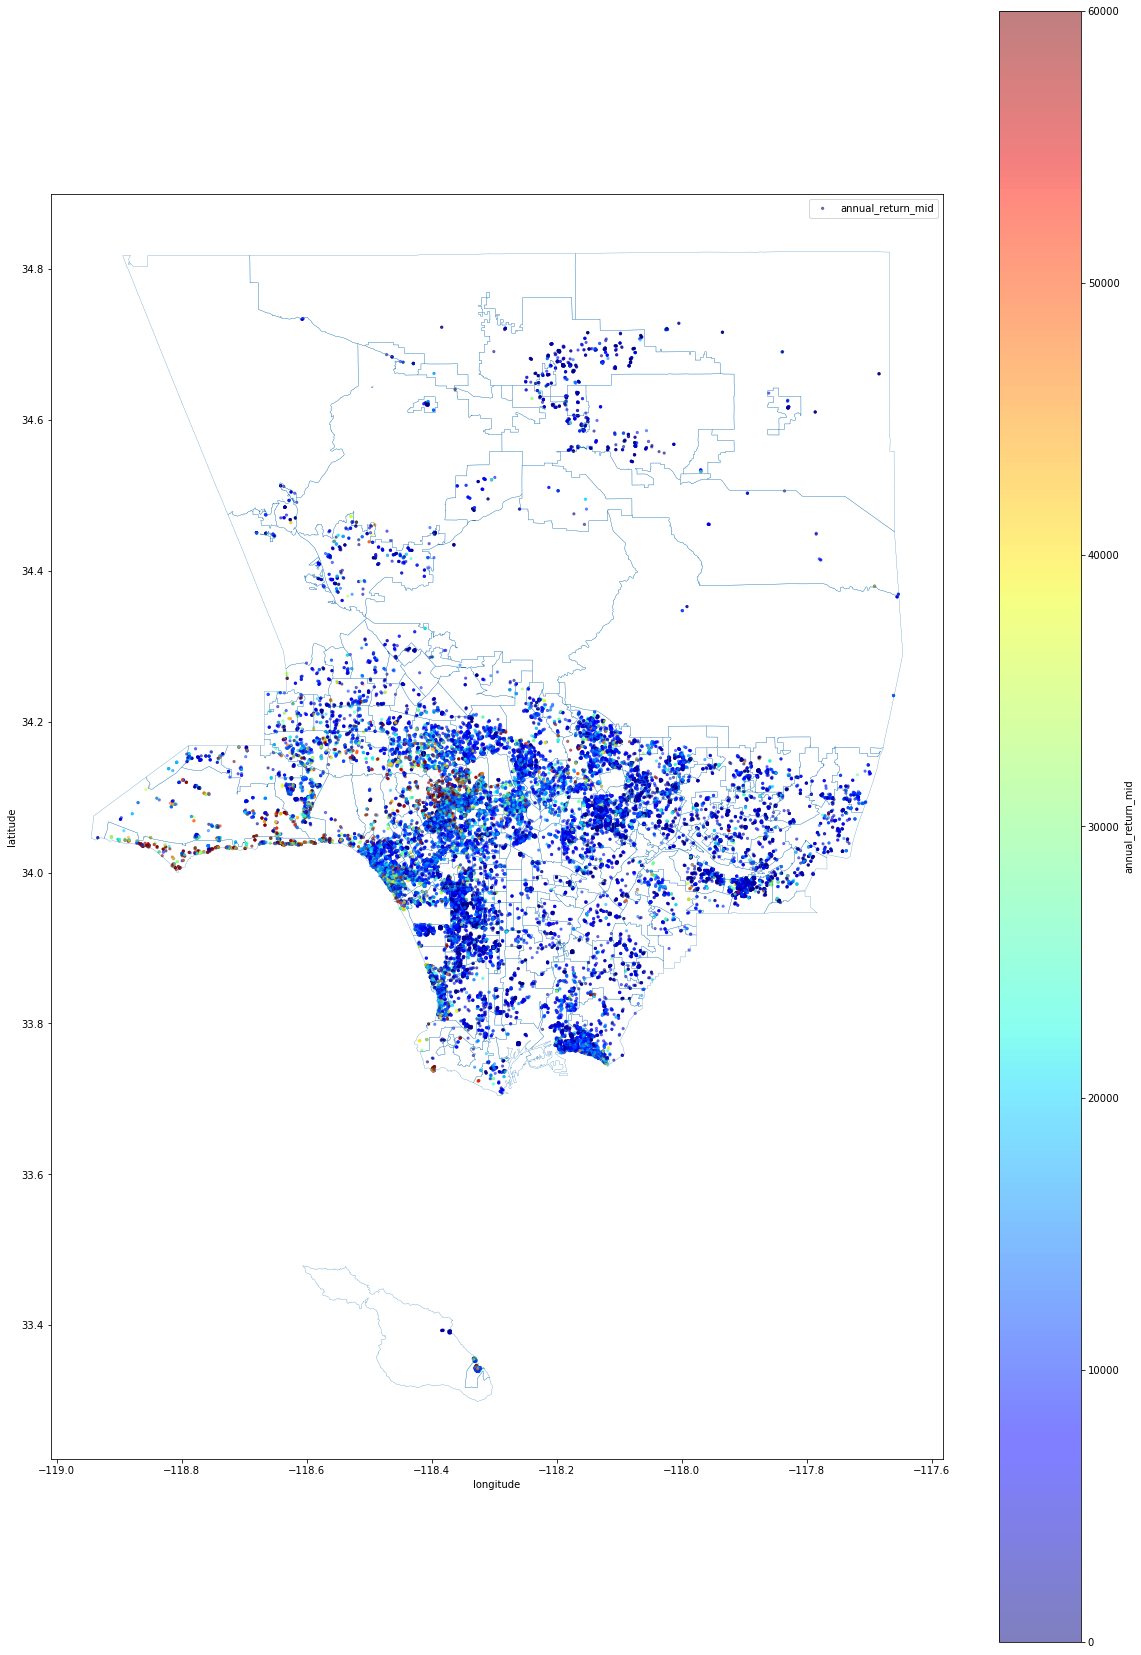

In [19]:
plt.figure(figsize=(20,30))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df_21.plot(kind='scatter', x='longitude', y='latitude', label='annual_return_mid', c='annual_return_mid',
                  cmap=plt.get_cmap('jet'), colorbar=True, s = 5, alpha=0.5, figsize=(20,30), ax=ax)

plt.legend()
plt.show()

# House Type

## House type vs. demand

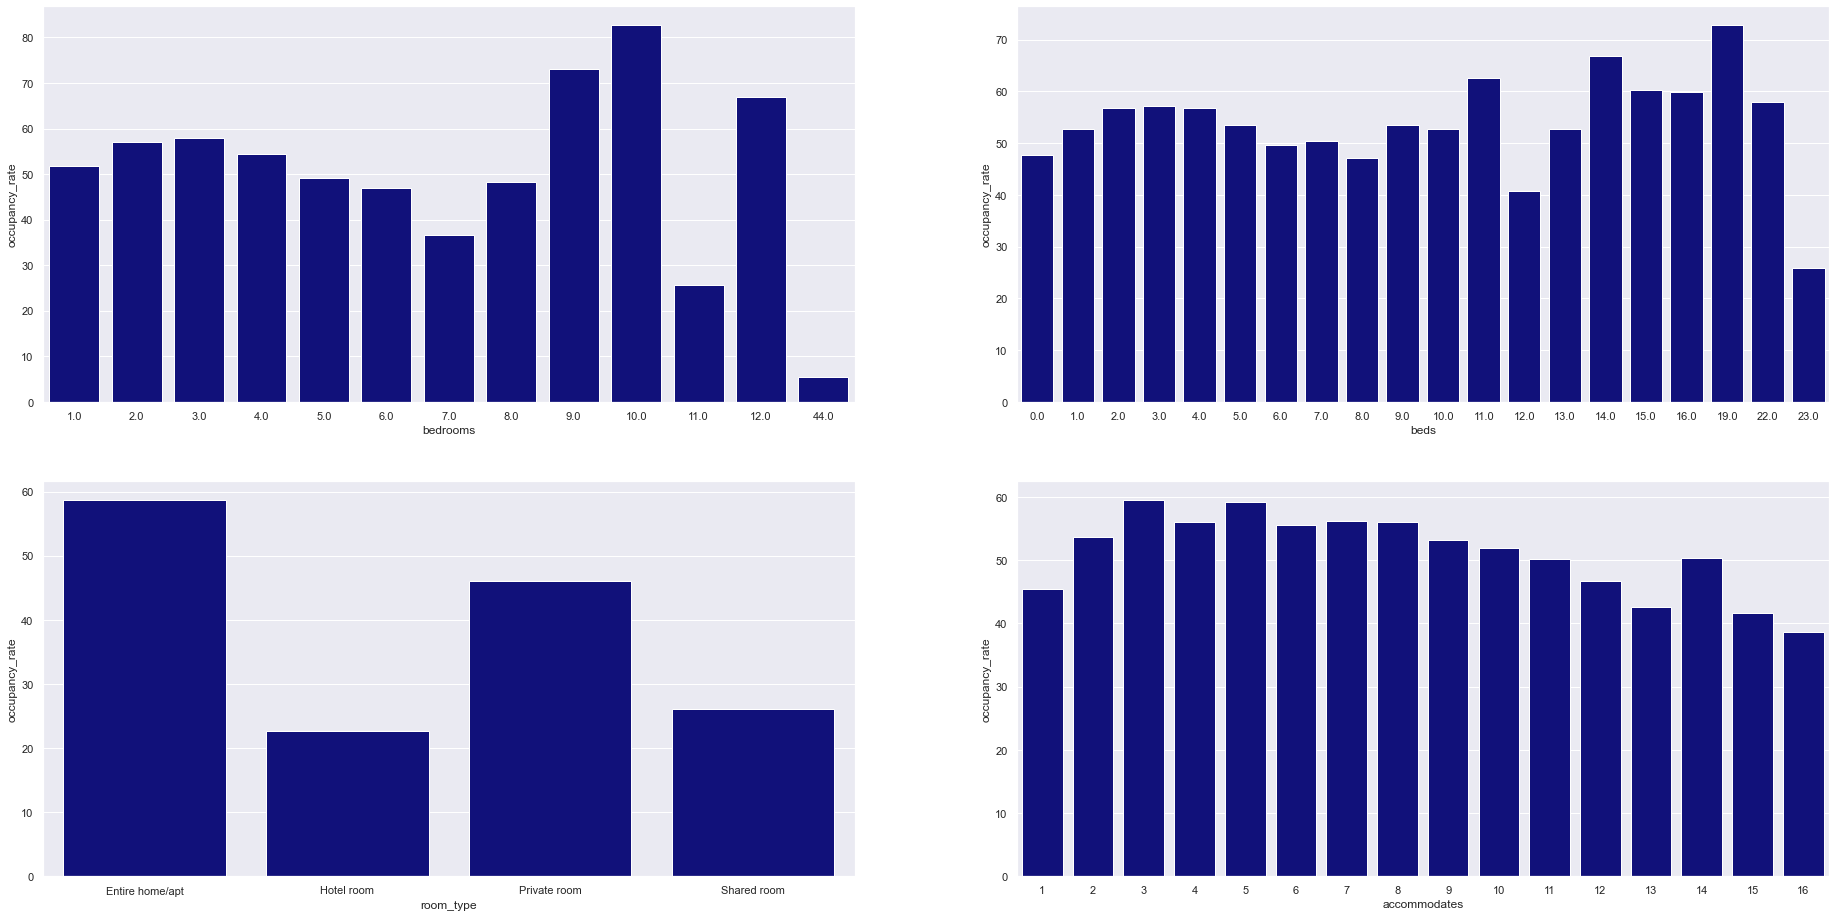

<Figure size 576x576 with 0 Axes>

In [20]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(32, 16))

# set the figure size
plt.figure(figsize=(8, 8))

bedrooms = df_21.groupby('bedrooms')['occupancy_rate'].mean().reset_index()

bar1 = sns.barplot(x="bedrooms",  y="occupancy_rate", data=bedrooms, ax=axes[0][0], color='darkblue')

beds = df_21.groupby('beds')['occupancy_rate'].mean().reset_index()

bar2 = sns.barplot(x="beds",  y="occupancy_rate", data=beds, ax=axes[0][1], color='darkblue')

room_type = df_21.groupby('room_type')['occupancy_rate'].mean().reset_index()

bar3 = sns.barplot(x="room_type",  y="occupancy_rate", data=room_type, ax=axes[1][0], color='darkblue')

accommodates = df_21.groupby('accommodates')['occupancy_rate'].mean().reset_index()

bar4 = sns.barplot(x="accommodates",  y="occupancy_rate", data=accommodates, ax=axes[1][1], color='darkblue')

# show the graph
plt.show()


## House type vs. price

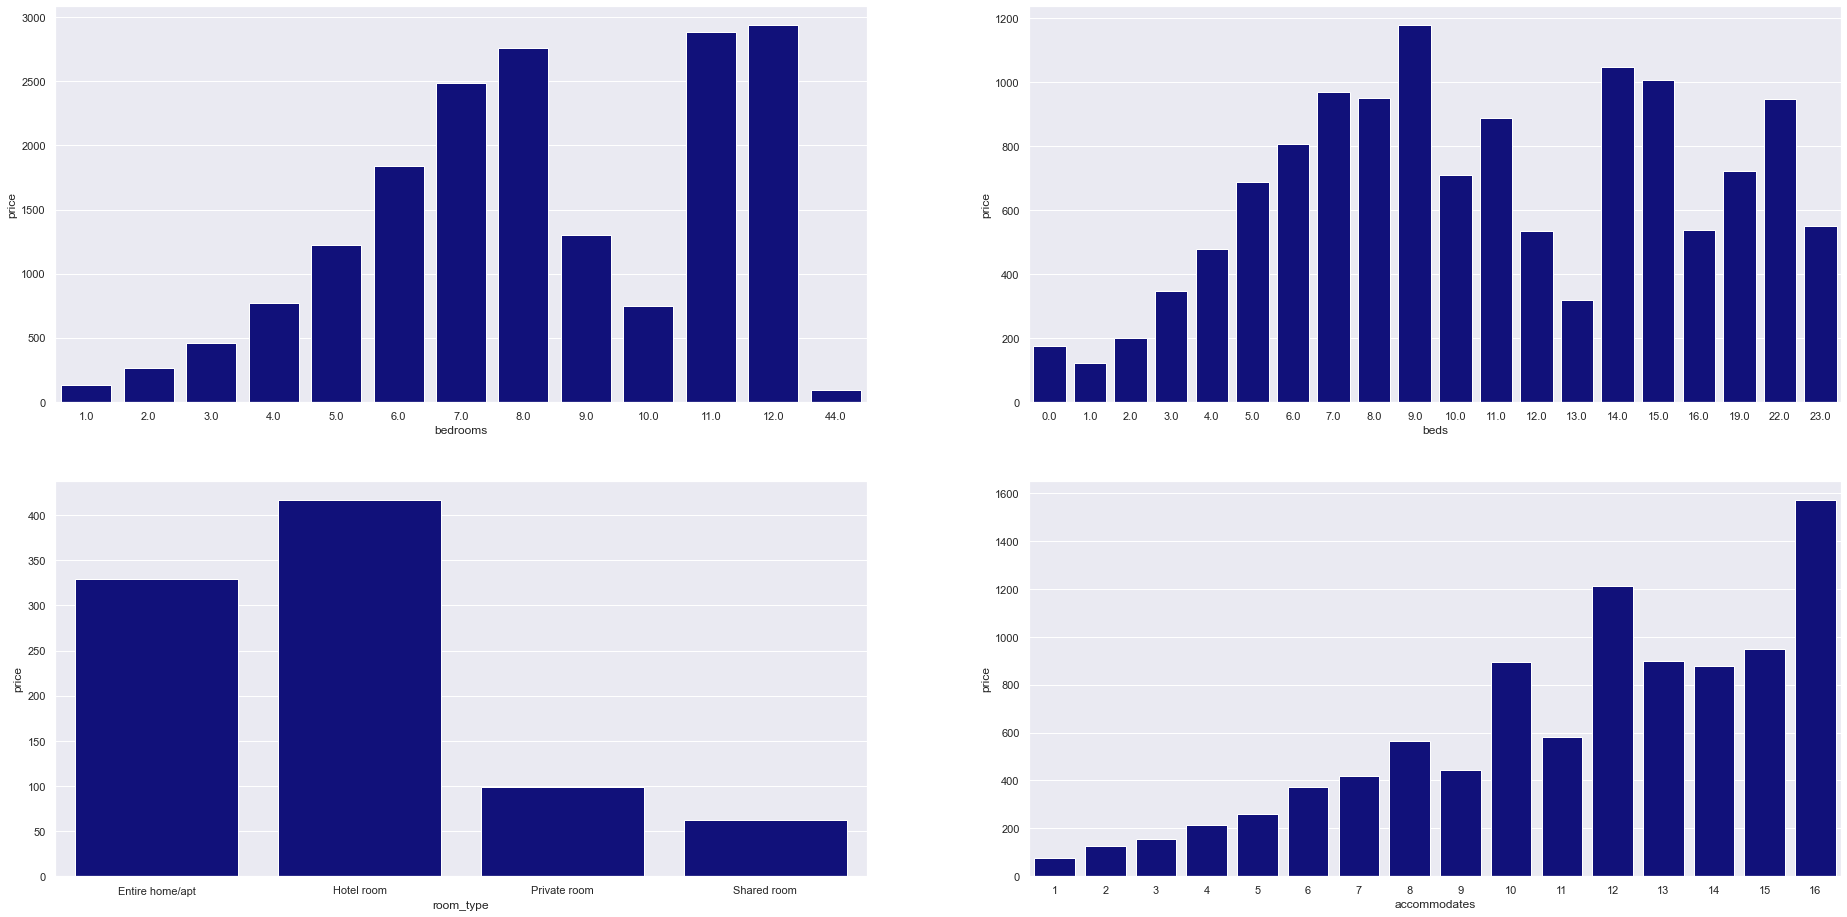

<Figure size 576x576 with 0 Axes>

In [21]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(32, 16))

# set the figure size
plt.figure(figsize=(8, 8))

bedrooms = df_21.groupby('bedrooms')['price'].mean().reset_index()

bar1 = sns.barplot(x="bedrooms",  y="price", data=bedrooms, ax=axes[0][0], color='darkblue')

beds = df_21.groupby('beds')['price'].mean().reset_index()

bar2 = sns.barplot(x="beds",  y="price", data=beds, ax=axes[0][1], color='darkblue')

room_type = df_21.groupby('room_type')['price'].mean().reset_index()

bar3 = sns.barplot(x="room_type",  y="price", data=room_type, ax=axes[1][0], color='darkblue')

accommodates = df_21.groupby('accommodates')['price'].mean().reset_index()

bar4 = sns.barplot(x="accommodates",  y="price", data=accommodates, ax=axes[1][1], color='darkblue')

# show the graph
plt.show()


## House type vs. Expected Revenue per year

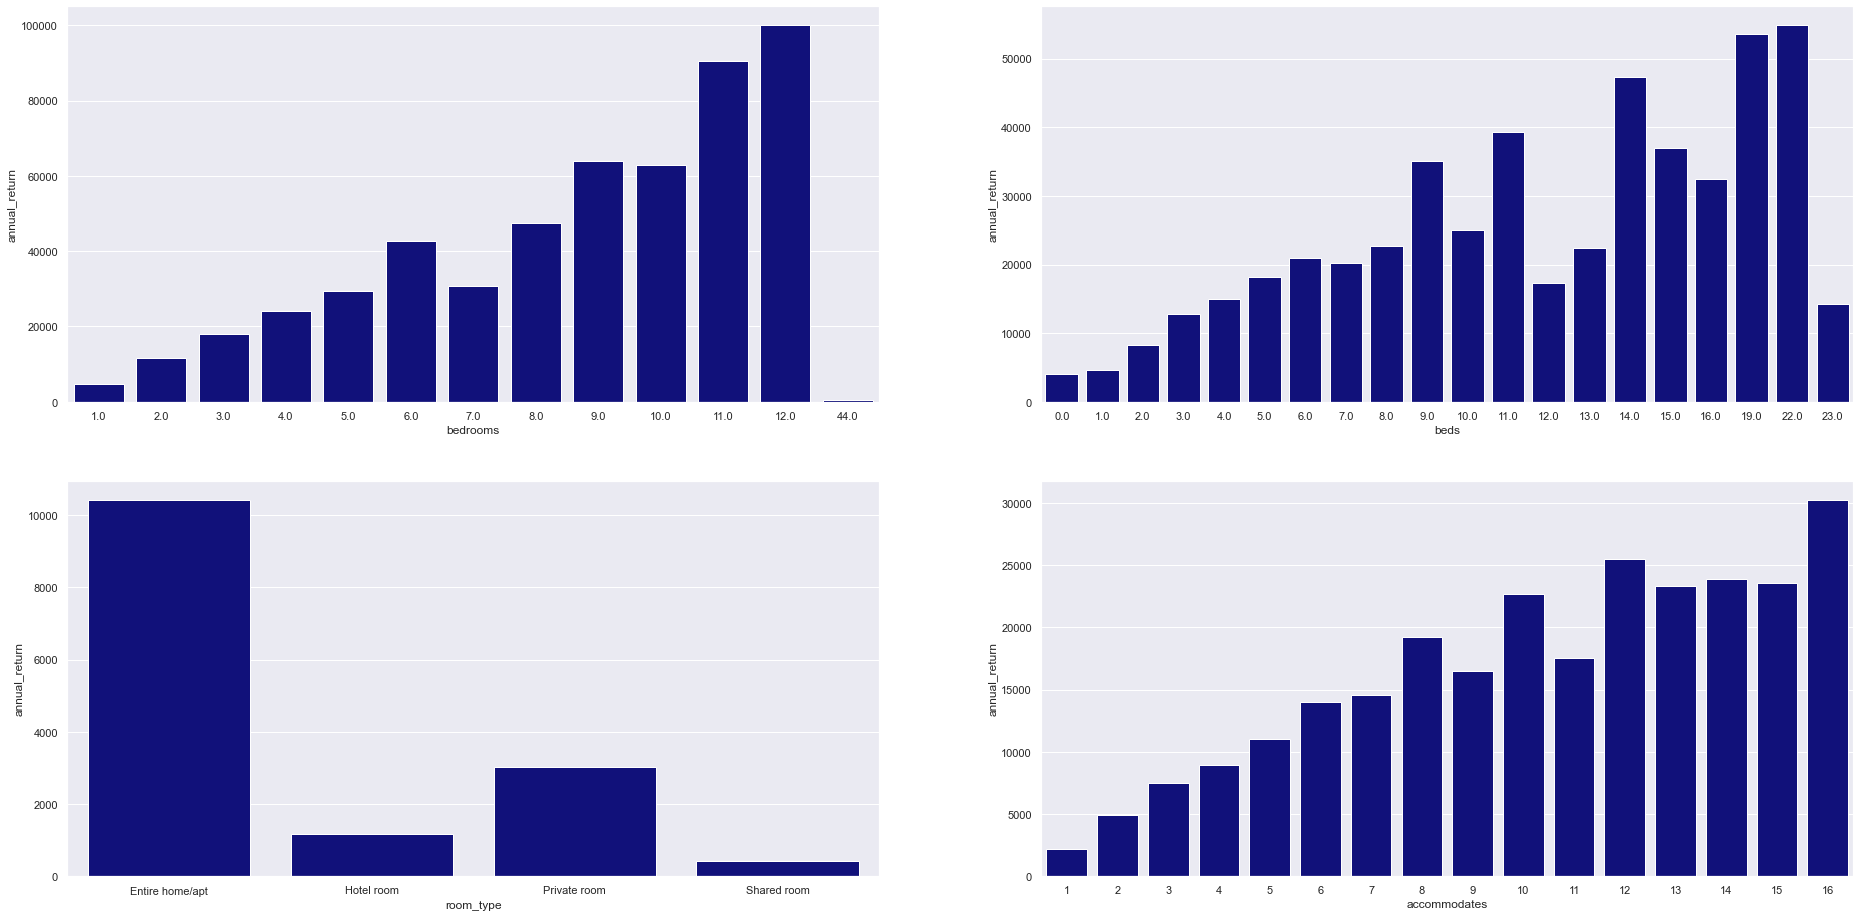

<Figure size 576x576 with 0 Axes>

In [22]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(32, 16))

# set the figure size
plt.figure(figsize=(8, 8))

bedrooms = df_21.groupby('bedrooms')['annual_return'].median().reset_index()

bar1 = sns.barplot(x="bedrooms",  y="annual_return", data=bedrooms, ax=axes[0][0], color='darkblue')

beds = df_21.groupby('beds')['annual_return'].median().reset_index()

bar2 = sns.barplot(x="beds",  y="annual_return", data=beds, ax=axes[0][1], color='darkblue')

room_type = df_21.groupby('room_type')['annual_return'].median().reset_index()

bar3 = sns.barplot(x="room_type",  y="annual_return", data=room_type, ax=axes[1][0], color='darkblue')

accommodates = df_21.groupby('accommodates')['annual_return'].median().reset_index()

bar4 = sns.barplot(x="accommodates",  y="annual_return", data=accommodates, ax=axes[1][1], color='darkblue')

# show the graph
plt.show()


We can focus on the bottom right chart, where it depicts the relationship between number of accommodates and price & demand. Unsurprisingly, we observe that accommodates is a very good covariate for predictin price. There is a clear positive relationship. Nonetheless, the relationship of occupancy rate vs. accommodates shows an increasing trend from 1 -- 5, peaked at 5 and then shows a decreasing trend. For the last chart, the interesting finding is that entire home/apt will generate a higher return for investors.

# Neighborhood Real-Estate Price

In [23]:
neighbor = pd.read_csv('Data/la_neighborhood.csv')

In [24]:
neighbor

,Legend,Neighborho,Geometry,Latitude (generated),Longitude (generated),Median Sale Price,Number of transactions
0,$10M<,"Malibu Road, Malibu Colony Beach",Polygon,34.031914,-118.707192,"$10,650,000",8
1,$10M<,Beverly Hills Gateway,Polygon,34.092866,-118.410102,"$10,050,000",18
2,$5M-$10M,Serra Retreat,Polygon,34.041210,-118.679757,"$5,475,000",5
3,$5M-$10M,Beverly Hills Flats,Polygon,34.078675,-118.412741,"$7,450,000",24
4,$5M-$10M,Trousdale,Polygon,34.102484,-118.395982,"$8,535,000",9
...,...,...,...,...,...,...,...
210,<$500K,Lincoln Heights,Polygon,34.075917,-118.205180,"$494,000",32
211,<$500K,Canoga Park,Polygon,34.207976,-118.598290,"$475,000",178
212,<$500K,Panorama City,Polygon,34.229426,-118.449228,"$436,000",159
213,<$500K,Pacoima,Polygon,34.267070,-118.411859,"$430,000",181


In [25]:
neighbor_housing_price = {}
for index, row in la_map.iterrows():
    for i, n in neighbor.iterrows():
        if row['geometry'].contains(Point(float(n['Longitude (generated)']), float(n['Latitude (generated)']))):
            price =  n['Median Sale Price']
            price = float(price[1:].replace(",",""))
            neighbor_housing_price[row['neighbourhood']] = price

In [26]:
ncr = pd.DataFrame.from_dict(neighbor_housing_price, orient='index').reset_index()
ncr.columns = ["neighbourhood_cleansed", "housing_sale"]
ncr

,neighbourhood_cleansed,housing_sale
0,Del Aire,747000.0
1,Ladera Heights,1367000.0
2,Chesterfield Square,445000.0
3,Topanga,2360000.0
4,Unincorporated Santa Susana Mountains,627250.0
...,...,...
111,Watts,333853.0
112,West Adams,680000.0
113,Windsor Square,2350000.0
114,West Hills,678500.0


In [27]:
df_21 = pd.merge(df_21, ncr, on='neighbourhood_cleansed', how='inner')

Create a new column about return on investment, defined by annual revenue over median housing price in percentage 

In [28]:
df_21['roi'] = df_21['annual_return']/df_21['housing_sale']

In [29]:
# df_21['roi']#[df_21['roi'] >= 0.17] = 0.17

<Figure size 1440x2160 with 0 Axes>

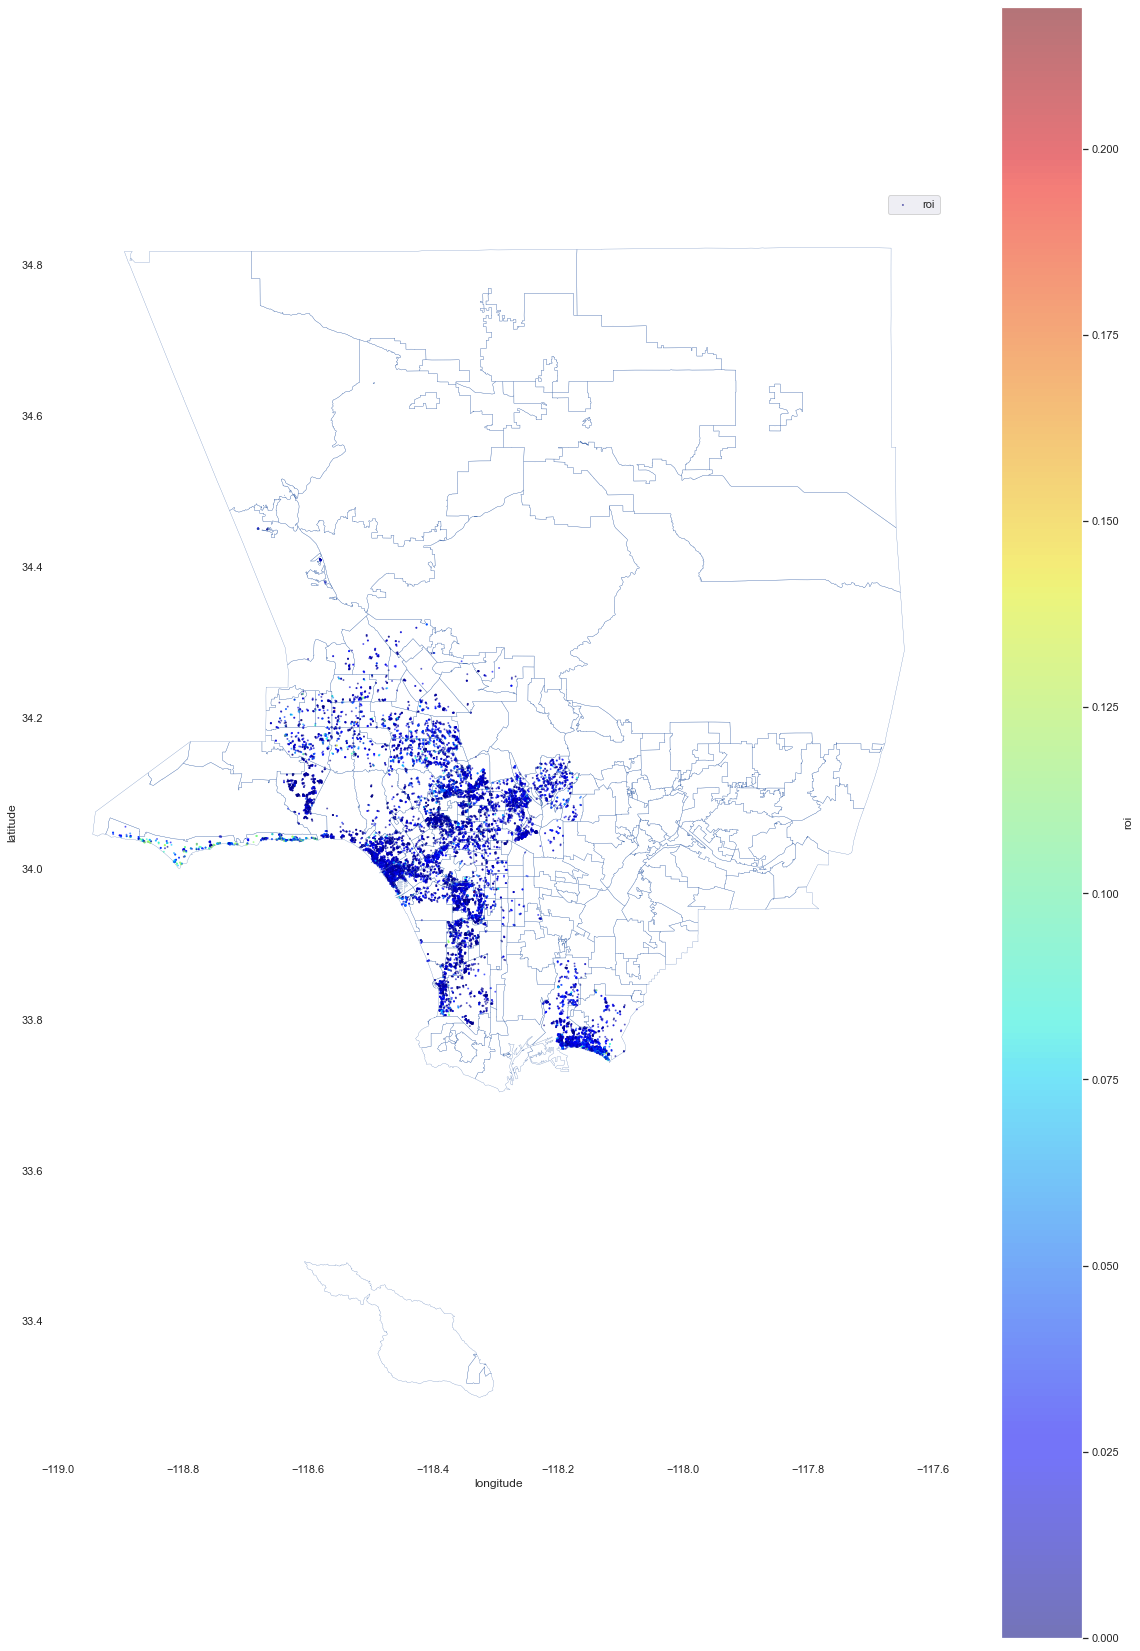

In [30]:
plt.figure(figsize=(20,30))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df_21.plot(kind='scatter', x='longitude', y='latitude', label='roi', c='roi',
                  cmap=plt.get_cmap('jet'), colorbar=True, s = 1, alpha=0.5, figsize=(20,30), ax=ax)

plt.legend()
plt.show()

The map above show where to invest in LA. Except for the Malibu and Beverly Hills areas, ROI for airbnbs in most LA areas are smaller than 0.06, meaning it will need 17 years of airbnb renting to cover one's house price in general in LA. As for some suggestions, we would recommand short-term renting investors to invest in Malibu or Beverly Hill if investors have the moneytary power to do so, of course.

# Crime Rate

## Web scraping crime rate

In [31]:
'''
def scrape_crime_rate(neighbor):
    neighbor = neighbor.lower().replace(" ","-")
    URL = "https://www.neighborhoodscout.com/ca/"+neighbor+"/crime"
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    score = soup.findAll('h1', attrs={"class":"score"})#[0]
    if score == [] or len(score) > 1:
        return(-1)
    return(int(score[0].text))
    
'''
def scrape_crime_rate(neighbor, verbose=0):
    neighbor = neighbor.lower().replace(" ","-")
    URL = "https://www.homefacts.com/crime/California/Los-Angeles-County/"+neighbor+".html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    score = soup.findAll('div', attrs = {"class": "crime_compare_col2 subtotal_col2"})
    if score == []:
        return(-1)
    if verbose == 1:
        print(neighbor)
        print(score)
        print("|--------------------------------------|")
    
    return(int(score[0].text.replace(",","")))

In [ ]:
neighbor_crime_rate = {}
for neighbor in df_21["neighbourhood_cleansed"].unique():
    crime_rate = scrape_crime_rate(neighbor, verbose=0)
    if crime_rate != -1:
        neighbor_crime_rate[neighbor] = crime_rate

In [ ]:
ncr = pd.DataFrame.from_dict(neighbor_crime_rate, orient='index').reset_index()
ncr.columns = ["neighbourhood_cleansed", "crime_rate"]
ncr
ncr.to_csv('crime_rate.csv')

In [ ]:
ncr = ncr[ncr['crime_rate'] <= 1000]

In [ ]:
ncr['crime_rate'].describe()

Joining crime-rate to the original df

In [ ]:
df_21 = pd.merge(df_21, ncr, on='neighbourhood_cleansed', how='inner')

In [ ]:
df_21.shape

## Occupancy Rate vs. Crime Rate

In [ ]:
sns.kdeplot(x=df_21.crime_rate, y=df_21.occupancy_rate, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

## Price per night vs. Crime Rate

In [ ]:
sns.kdeplot(x=df_21.crime_rate[df_21['price'] < 1200], y=df_21.price[df_21['price'] < 1200], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

## Revenue per year vs. Crime Rate

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(x=df_21.crime_rate[df_21['price'] < 1200], y=df_21.price[df_21['price'] < 1200] * df_21.occupancy_rate[df_21['price'] < 1200] / 100 * 365, cmap="Reds", shade=True, bw_adjust=.5, ax=ax)
ax.set_ylim(0,150000)
plt.show()

From the plots above, we can still observe that listings in higher crime rate regions tend to have lower occupancy rate. However, we see that crime rate, as an individual factor, does not explain the demand very well. The reason is that metro areas, where airbnb listings demand is high, tend to have a higher crime rate. This factor both affects the crime rate, and the demand we are analyzing.